<h3 align=middle style="line-height:500%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Project Three, Question Two, Parts One and Two
</font>
</h3>

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Part 1:
</font>
</h3>

Preprocessing:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from wordcloud import WordCloud
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import multiprocessing
import tensorflow as tf
nltk.download("stopwords")
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

c:\Users\ROG\anaconda3\envs\MLB\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\train_data.csv")
test = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\test_data.csv")
titles = pd.read_csv(r"C:\Users\ROG\Desktop\Worklife\Data\MLBootcamp\Project3\Part2\Data\title_brand.csv")

In [3]:
train = train.merge(titles, on="asin", how="left")

In [4]:
train.isna().sum()

overall                0
vote              660980
verified               0
reviewTime             0
reviewerID             0
asin                   0
style             353595
reviewerName         235
reviewText             0
summary               78
unixReviewTime         0
title                 78
brand               1235
dtype: int64

In [5]:
test.isna().sum()

vote              15067
verified              0
reviewTime            0
reviewerID            0
asin                  0
style              8496
reviewerName          4
reviewText            0
summary               2
unixReviewTime        0
dtype: int64

We need to handle the Nan values.

"vote" nans are where there has been no helpful vote for the review, therefore we will fill the nan values in this column with 0s.

"reviewerName" is not that important in our sentiment analysis and the number of nan data is limited so we won't be needing to handel that.

"summary" is not pretty important too and because of the number of nans compared to the whole dataset, we will not interfere in this case too.

"style" won't affect the result much (or at least shouldn't), and thence we will drop the respective column.

We also have a time column so probably there is no need for "unixTime".

"brand" and "title" columns won't be used in our DL parts and we will only use it in analytical parts.

In [6]:
train.drop(columns=['style', 'unixReviewTime'], inplace=True)
test.drop(columns=['style', 'unixReviewTime'], inplace=True)

train["vote"].fillna(0, inplace=True)
test["vote"].fillna(0, inplace=True)

In [7]:
train.isna().sum(), train.shape

(overall            0
 vote               0
 verified           0
 reviewTime         0
 reviewerID         0
 asin               0
 reviewerName     235
 reviewText         0
 summary           78
 title             78
 brand           1235
 dtype: int64,
 (855679, 11))

In [8]:
test.isna().sum(), test.shape

(vote            0
 verified        0
 reviewTime      0
 reviewerID      0
 asin            0
 reviewerName    4
 reviewText      0
 summary         2
 dtype: int64,
 (20000, 8))

Now that we have handled nans, we can check our datatypes and other things:

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855679 entries, 0 to 855678
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   overall       855679 non-null  int64 
 1   vote          855679 non-null  object
 2   verified      855679 non-null  bool  
 3   reviewTime    855679 non-null  object
 4   reviewerID    855679 non-null  object
 5   asin          855679 non-null  object
 6   reviewerName  855444 non-null  object
 7   reviewText    855679 non-null  object
 8   summary       855601 non-null  object
 9   title         855601 non-null  object
 10  brand         854444 non-null  object
dtypes: bool(1), int64(1), object(9)
memory usage: 66.1+ MB


In [10]:
train

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,title,brand
0,2,0,False,2016-11-11,A2OSUEZJIN7BI,0511189877,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC
1,5,0,True,2016-06-06,A2NETQRG6JHIG7,0511189877,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC
2,4,0,True,2016-03-10,A12JHGROAX49G7,0511189877,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC
3,5,0,True,2016-01-14,A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC
4,5,0,True,2016-10-20,A280POPEWI0NSA,0594459451,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble
...,...,...,...,...,...,...,...,...,...,...,...
855674,5,0,True,2017-07-25,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,These are my favorite charging cords for a few...,Worth the price.,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO
855675,1,0,True,2017-04-04,A77K1B31UAQ29,B01HJCN1EI,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO
855676,3,0,True,2017-07-08,A2SVXUVUAWUDK2,B01HJH42KU,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...,Jricoo Nylon Braided 2.0 Micro USB Charging Ca...,Jricoo
855677,5,2.0,True,2016-12-01,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,Jricoo 3pack 6ft Micro USB to USB Cable 2.0 6f...,Jricoo


In [11]:
train["vote"] = train['vote'].astype(str).str.replace(",", '')
test['vote'] = test['vote'].astype(str).str.replace(",", '')

In [12]:
train[['verified']] = train[['verified']].replace([False, True], [0, 1])
test[['verified']] = test[['verified']].replace([False, True], [0, 1])

train['vote'] = pd.to_numeric(train['vote'])
test['vote'] = pd.to_numeric(test['vote'])

train["reviewTime"] = pd.to_datetime(train["reviewTime"])
test["reviewTime"] = pd.to_datetime(test["reviewTime"])

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855679 entries, 0 to 855678
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   overall       855679 non-null  int64         
 1   vote          855679 non-null  float64       
 2   verified      855679 non-null  int64         
 3   reviewTime    855679 non-null  datetime64[ns]
 4   reviewerID    855679 non-null  object        
 5   asin          855679 non-null  object        
 6   reviewerName  855444 non-null  object        
 7   reviewText    855679 non-null  object        
 8   summary       855601 non-null  object        
 9   title         855601 non-null  object        
 10  brand         854444 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 71.8+ MB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   vote          20000 non-null  float64       
 1   verified      20000 non-null  int64         
 2   reviewTime    20000 non-null  datetime64[ns]
 3   reviewerID    20000 non-null  object        
 4   asin          20000 non-null  object        
 5   reviewerName  19996 non-null  object        
 6   reviewText    20000 non-null  object        
 7   summary       19998 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.2+ MB


Finally we will go for the questions:

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 1:
</font>
</h3>

Checking for imbalancement:

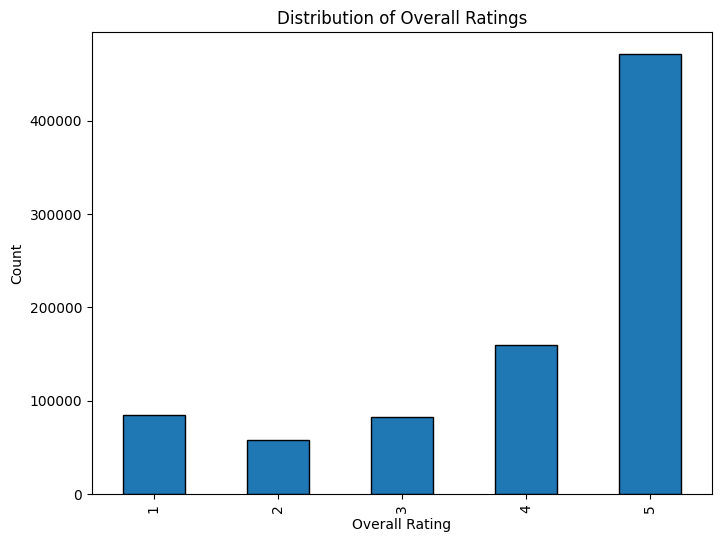

In [15]:
plt.figure(figsize=(8, 6))
train['overall'].value_counts().sort_index().plot(kind='bar', edgecolor='black')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
plt.show()

Adding some mathematical backbone to our implentation:

In [16]:
rating_distribution = train['overall'].value_counts().sort_index()
is_balanced = rating_distribution.min() / rating_distribution.max() >= 0.7
print("Is the dataset balanced?", is_balanced)

Is the dataset balanced? False


As it is shown, we need to handle the imbalancement.

We need to make sure that no overfitting is being made, so if we have got overfitting in our final results this is a checkpoint for sure!

We will use the IMBlearn random oversampler and undersampler for the purpose and in order to make a cautious step overfitting wise, we will bring all the samples to 250000 occurances:

In [17]:
train["overall"].value_counts()

overall
5    471415
4    159289
1     84411
3     82796
2     57768
Name: count, dtype: int64

In [18]:
undersampler = RandomUnderSampler(sampling_strategy={1: 82950, 2: 56756, 3: 81239, 4: 149999, 5: 149999}, random_state=78)
oversampler = RandomOverSampler(sampling_strategy={1: 150000, 2: 150000, 3: 150000, 4: 150000, 5: 150000}, random_state=78)

X_resampledo, y_resampledo = undersampler.fit_resample(train.drop(columns=["overall"]), train['overall'])
X_resampled, y_resampled = oversampler.fit_resample(X_resampledo, y_resampledo)

In [19]:
balanced_distribution = y_resampled.value_counts().sort_index()
print("Balanced Rating Distribution:")
print(balanced_distribution)

Balanced Rating Distribution:
overall
1    150000
2    150000
3    150000
4    150000
5    150000
Name: count, dtype: int64


We will use this method when encountering the main model training results and not in the analytical parts.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 2:
</font>
</h3>


After the imbalancement handling, we will go for positive, neutral, and negative wordclouds:

In [20]:
positive_reviews = train[train['overall'].isin([4, 5])]
neutral_reviews = train[train['overall'] == 3]
negative_reviews = train[train['overall'].isin([1, 2])]
positive_text = " ".join(positive_reviews['reviewText'])
neutral_text = " ".join(neutral_reviews['reviewText'])
negative_text = " ".join(negative_reviews['reviewText'])
stop_words = set(stopwords.words('english'))

In [21]:
wordcloud_positive = WordCloud(stopwords=stop_words, background_color='white').generate(positive_text)
wordcloud_neutral = WordCloud(stopwords=stop_words, background_color='white').generate(neutral_text)
wordcloud_negative = WordCloud(stopwords=stop_words, background_color='white').generate(negative_text)

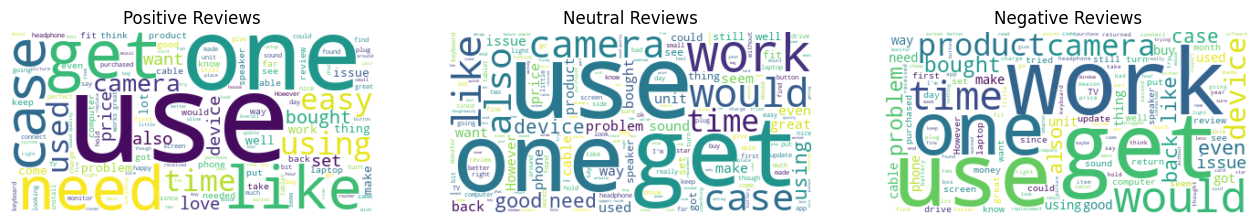

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")

plt.subplot(132)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")

plt.show()

There are some words and verbs in english language that may be repeated in all classes. For instance, "product" is something that can be referred in all classes.

"need" and "work" are some verbs that have no meaning when used alone. For example you can say: 'This camera works well' and 'This camera doesen't work at all.'.

There are some other words like these examples that don't add much to our wordcloud's purpose and since we will get rid of them. 

As we discussed, we still have some words that are not meant to be there and they are in common between all classes so we will try to delete them too in order to get a better result:

In [23]:
stop_words.add('one')
stop_words.add('get')
stop_words.add('camera')
stop_words.add('need')
stop_words.add('product')
stop_words.add('work')
stop_words.add('time')
stop_words.add('use')
stop_words.add('device')
stop_words.add('would')
stop_words.add('could')
stop_words.add('used')
stop_words.add('using')
stop_words.add('thing')
stop_words.add('unit')
stop_words.add('got')
stop_words.add('however')
stop_words.add('also')
stop_words.add('bought')
stop_words.add('case')
stop_words.add('like')
stop_words.add('even')

In [24]:
wordcloud_positive = WordCloud(stopwords=stop_words, background_color='white').generate(positive_text)
wordcloud_neutral = WordCloud(stopwords=stop_words, background_color='white').generate(neutral_text)
wordcloud_negative = WordCloud(stopwords=stop_words, background_color='white').generate(negative_text)

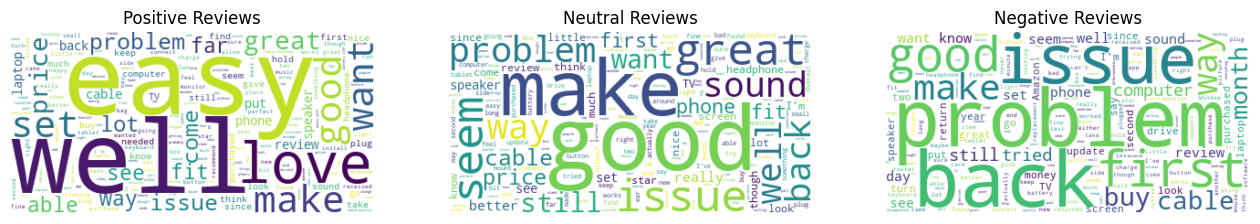

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")

plt.subplot(132)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")

plt.subplot(133)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")

plt.show()

There are still some duplicates like the other wordcloud that we discussed about but as you can see, the positive words in the positive class are much more bold, the negative ones are much more bold in the negative class and both of negative and positive words have been repeated a lot in the neutral class. 

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 3:
</font>
</h3>


Now we will find the top 10 useful users:

In [26]:
top_reviewers = pd.DataFrame(train.groupby(['reviewerID', 'reviewerName']).agg(Mean=('vote', np.mean),Sum=('vote', np.sum))).reset_index()
top_reviewers['Count'] = top_reviewers["Sum"]/ top_reviewers["Mean"]
top_reviewers.drop(columns=["Mean"], inplace=True)
top_reviewers = top_reviewers.sort_values(by='Sum', ascending=False)
top_10_reviewers = top_reviewers.head(10)
t10df = pd.DataFrame(top_10_reviewers[['reviewerName', 'Sum', "Count"]])
print("Top 10 Reviewers with Most Votes:")
t10df

Top 10 Reviewers with Most Votes:


,reviewerName,Sum,Count
98734,Benson Leung,4572.0,29.0
220238,Voltron00x,3181.0,9.0
129947,Obi Wan,3150.0,29.0
49214,nycebo,2978.0,2.0
293333,Mayra S.,2631.0,20.0
271095,Cthulhu,2607.0,32.0
39282,Chris Upton,2167.0,5.0
315384,Sally B.,1912.0,5.0
179190,DJ,1867.0,24.0
161044,Mark A. Baker,1820.0,1.0


In this version you can see in how many comments have the users achieved that much of "useful" votes.

In other words, "Sum" is how many useful votes have a reviewer recieved and "Count" shows the number of comments they recieved that much attention with.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 4:
</font>
</h3>


Original one :

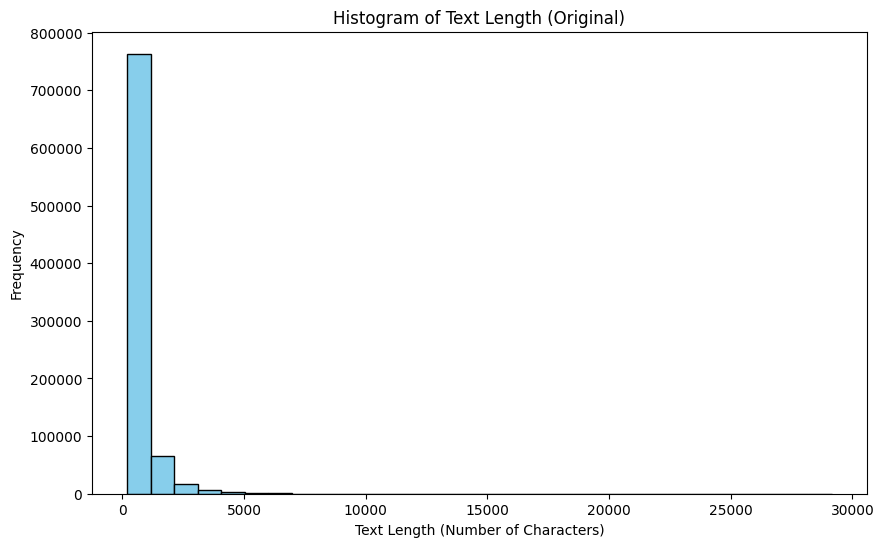

In [27]:
train['text_length'] = train['reviewText'].str.len()

plt.figure(figsize=(10, 6))
plt.hist(train['text_length'], bins=30, color='skyblue', edgecolor="black")
plt.title('Histogram of Text Length (Original)')
plt.xlabel('Text Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

Let's find the filter boundaries with the IQR method:

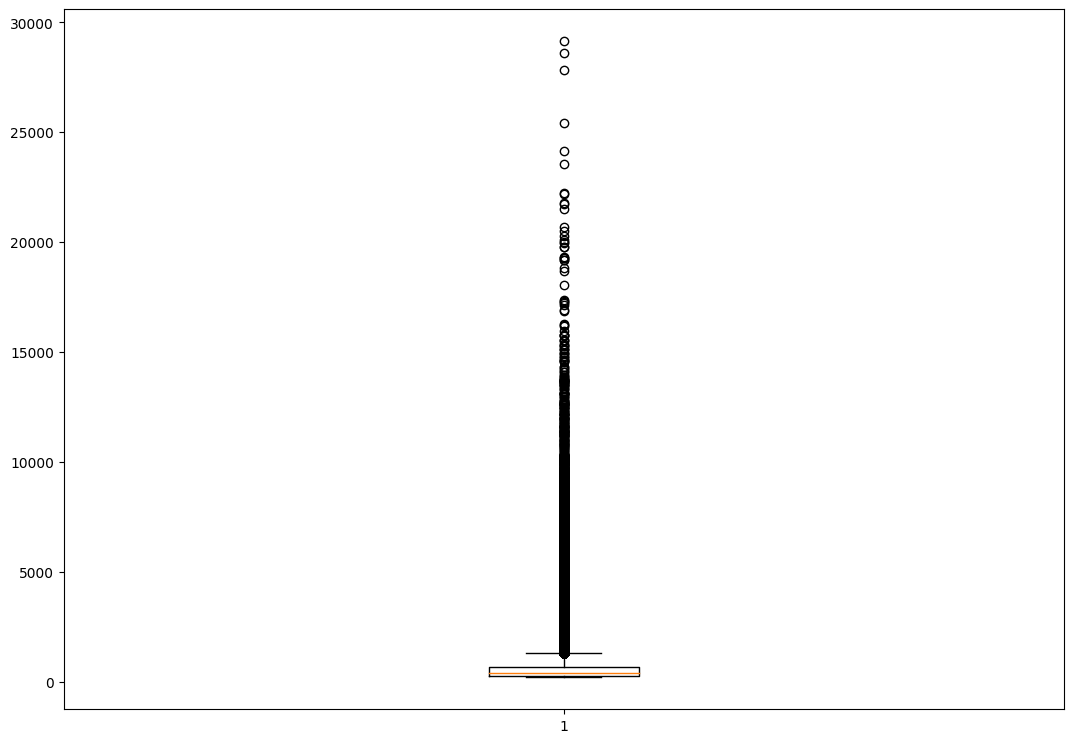

In [28]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot((train["text_length"]))
plt.show()

In [29]:
m = np.mean(train["text_length"])
q3, q1 = np.percentile(train["text_length"], [75 ,25])
iqr = q3 - q1
lower = m - 1.5*iqr
upper = m + 1.5*iqr
(lower, upper)

(-3.7760889305452565, 1250.2239110694547)

We don't have a -5 characters long word, so we will consider the lower bound as 0.

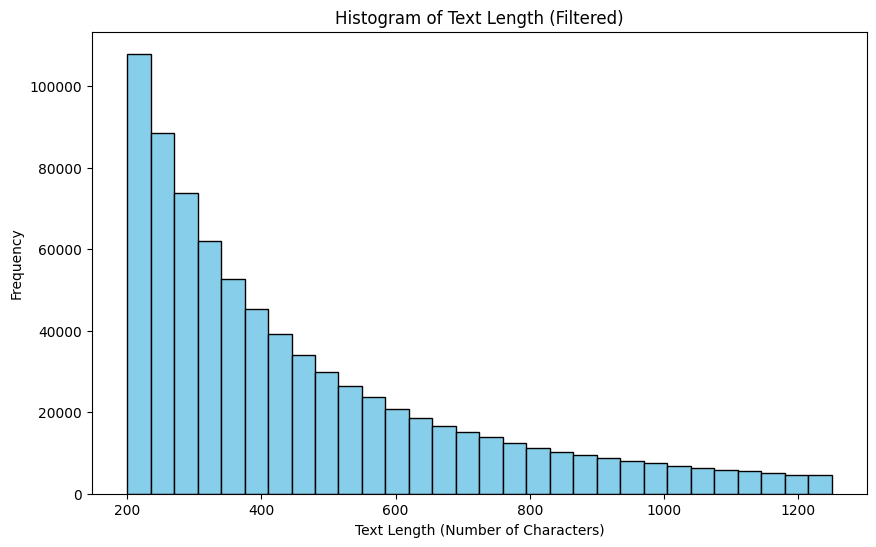

In [30]:
filtered_data = train[(train['text_length'] >= 0) & (train['text_length'] <= upper)]

plt.figure(figsize=(10, 6))
plt.hist(filtered_data['text_length'], bins=30, color='skyblue', edgecolor="black")
plt.title('Histogram of Text Length (Filtered)')
plt.xlabel('Text Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

Based on the analysis of the histogram of text lengths, it seems that setting a constraint on the text length during modeling could be beneficial. 

The filtered histogram with a minimum of 0 characters and a maximum of approximately 1250 characters resulted in a smoother distribution of text lengths.

Therefore, it is advisable to impose constraints on the text length during modeling.

After a little explanatory data review you will find out that the min count of characters used in a comment is 200 and therefore our actual interval is (200, 1250) characters.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 5:
</font>
</h3>

10 most five stars

In [31]:
five_star_reviews = train[train['overall'] == 5]
five_star_reviews

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,title,brand,text_length
1,5,0.0,1,2016-06-06,A2NETQRG6JHIG7,0511189877,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,450
3,5,0.0,1,2016-01-14,A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,284
4,5,0.0,1,2016-10-20,A280POPEWI0NSA,0594459451,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble,247
5,5,0.0,1,2016-06-18,A2KTAT1Y3VRVSJ,0594459451,MnMMom3,This is a great charging cable for the Nook. ...,Better than original charger!,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble,266
6,5,0.0,1,2016-02-11,A1CHTT6E3NV5YL,0594459451,Amazon Shopper,The 90 degree connector is a bonus that allows...,Works great on my Wife's older model Nook Color.,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble,282
...,...,...,...,...,...,...,...,...,...,...,...,...
855670,5,0.0,1,2017-07-13,A1OOVLE2KZ6KGA,B01HJCN5GC,Puddzee,These are very nice cables. I like the heavy w...,Nice,Micro USB Charger10 Feet Extra long and Fast A...,DEEGO,209
855673,5,0.0,1,2018-06-07,AFAI8GK0O6ZZG,B01HJDR9DQ,JJC3,Fits the old cordless phones just fine and wor...,Fits and works. No issues.,Geilienergy BT-17333 BT-27333 Handset Telephon...,GEILIENERGY,434
855674,5,0.0,1,2017-07-25,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,These are my favorite charging cords for a few...,Worth the price.,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO,276
855677,5,2.0,1,2016-12-01,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,Jricoo 3pack 6ft Micro USB to USB Cable 2.0 6f...,Jricoo,528


In [32]:
top_products = five_star_reviews.groupby(['asin', 'brand', 'title'])['overall'].count().reset_index()
top_products = top_products.rename(columns={'overall': 'num_5_star_reviews'})
top_products = top_products.sort_values(by='num_5_star_reviews', ascending=False)
top_products

,asin,brand,title,num_5_star_reviews
49255,B010OYASRG,Cambridge Soundworks,OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...,1163
32860,B00L0YLRUW,NETGEAR,NETGEAR N300 WiFi Range Extender (EX2700),659
65009,B01DA0YCNC,Roku,Roku Streaming Stick (3600R) - HD Streaming Pl...,600
4475,B000VS4HDM,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...,598
9501,B0043T7FXE,Logitech,Logitech M570 Wireless Trackball Mouse &ndash;...,552
...,...,...,...,...
18910,B00AWL6G8W,BobjGear,BobjGear 90 Degree Bend Low Profile OTG Cable ...,1
18913,B00AWM12H6,NEC,NEC MultiSync EA244WMI-BK 24-Inch Screen LED-L...,1
18914,B00AWN8ILI,Sharkoon,Sharkoon 5.25-Inch BAYEXTENSION Mounting Frame...,1
18915,B00AWPO2RU,Daffodil,Daffodil WMS106 Wired Mini Optical Mouse - 3 B...,1


In [33]:
top_10_products = top_products.head(10)
t10pdf = pd.DataFrame(top_10_products[['brand', 'title', 'num_5_star_reviews']])
print("10 most five stars rated products:")
t10pdf

10 most five stars rated products:


,brand,title,num_5_star_reviews
49255,Cambridge Soundworks,OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...,1163
32860,NETGEAR,NETGEAR N300 WiFi Range Extender (EX2700),659
65009,Roku,Roku Streaming Stick (3600R) - HD Streaming Pl...,600
4475,StarTech,StarTech USB 2.0 to SATA IDE Adapter (USB2SATA...,598
9501,Logitech,Logitech M570 Wireless Trackball Mouse &ndash;...,552
37411,Samsung,Samsung 850 EVO 500GB 2.5-Inch SATA III Intern...,529
1184,NETGEAR,NETGEAR 5-Port Gigabit Ethernet Unmanaged Swit...,482
41288,Asus,ASUS Tri-Band Gigabit (AC3200) WiFi Router (Up...,471
4599,VideoSecu,VideoSecu ML531BE TV Wall Mount for Most 27&qu...,448
38413,"Arlo Technologies, Inc",Arlo - Wireless Home Security Camera System | ...,433


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Question 6:
</font>
</h3>

10 most reviewed brands and their score mean 

In [116]:
brand_stats = train.groupby('brand').agg({'overall': ['count', 'mean']})
brand_stats.columns = ['num_reviews', 'average_rating']
top_10_brands = brand_stats.sort_values(by='num_reviews', ascending=False).head(10)
top_10_brands = top_10_brands.sort_values(by='average_rating', ascending=False)
top_10_brands

,num_reviews,average_rating
brand,,
Anker,9860,4.244320
AmazonBasics,13213,4.201468
Sabrent,7320,4.028005
SanDisk,8400,3.958810
Logitech,17066,3.954061
Samsung,15409,3.941268
Sony,12436,3.938726
TP-LINK,9773,3.928681
Asus,11928,3.855550


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Additional analyses:
</font>
</h3>

Now we will go for some general and statistical overview on our train data:

In [35]:
train.describe()

,overall,vote,verified,reviewTime,text_length
count,855679.000000,855679.000000,855679.000000,855679,855679.000000
mean,4.023198,1.710103,0.859089,2016-12-31 06:27:44.253066496,623.223911
min,1.000000,0.000000,0.000000,2016-01-01 00:00:00,200.000000
25%,3.000000,0.000000,1.000000,2016-05-31 00:00:00,277.000000
50%,5.000000,0.000000,1.000000,2016-11-16 00:00:00,407.000000
75%,5.000000,0.000000,1.000000,2017-07-08 00:00:00,695.000000
max,5.000000,2846.000000,1.000000,2018-10-03 00:00:00,29146.000000
std,1.343513,13.182358,0.347930,NaN,682.287431


In this view we can see that "overall" is really imbalanced in favor of 5 stars, "vote" is really imbalanced in favor of 0s, and "verified" is really imbalanced in favor of 1s.

Also most of our data is gathered before 2017, and our text lenghts vary a lot due to the respective std.

In [36]:
train

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,title,brand,text_length
0,2,0.0,0,2016-11-11,A2OSUEZJIN7BI,0511189877,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,561
1,5,0.0,1,2016-06-06,A2NETQRG6JHIG7,0511189877,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,450
2,4,0.0,1,2016-03-10,A12JHGROAX49G7,0511189877,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,205
3,5,0.0,1,2016-01-14,A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,284
4,5,0.0,1,2016-10-20,A280POPEWI0NSA,0594459451,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble,247
...,...,...,...,...,...,...,...,...,...,...,...,...
855674,5,0.0,1,2017-07-25,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,These are my favorite charging cords for a few...,Worth the price.,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO,276
855675,1,0.0,1,2017-04-04,A77K1B31UAQ29,B01HJCN1EI,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO,228
855676,3,0.0,1,2017-07-08,A2SVXUVUAWUDK2,B01HJH42KU,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...,Jricoo Nylon Braided 2.0 Micro USB Charging Ca...,Jricoo,242
855677,5,2.0,1,2016-12-01,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,Jricoo 3pack 6ft Micro USB to USB Cable 2.0 6f...,Jricoo,528


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
First Hypothesis:
</font>
</h3>

Is overall affected by weekday?

<Axes: ylabel='Frequency'>

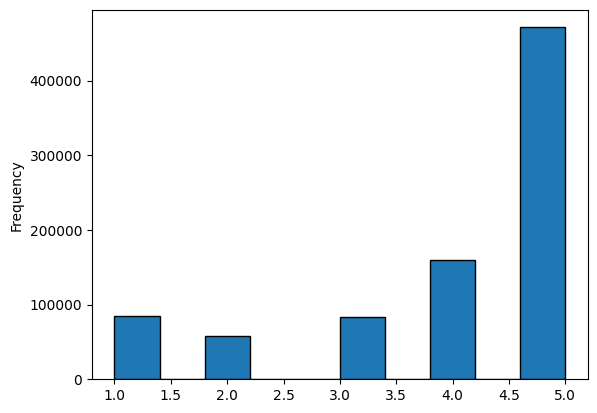

In [37]:
train['overall'].plot(kind='hist', edgecolor='black')

We already knew that this column isn't normal so we will use U-test for hypothesis testing.

First we will generate the data to compare weekdays and weekends and then we will use the U-test to do the Hypothesis testing:

X: weekends, Y: weekdays

H0 : μx < μy

H1 : μx >= μy

In [38]:
t = train.copy()
t["wd"] = t["reviewTime"].dt.weekday

In [39]:
twe = t[t["wd"]>=6]
twd = t[t["wd"]<6]

In [40]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(twe['overall'], twd['overall'], alternative="greater")
p_value

0.8474923496425621

We can say that people buying on weekdays are more likely to rate the product higher with a pretty good confidence level!

In [41]:
twe["overall"].mean(), twd["overall"].mean()

(4.015774539947266, 4.0242885405161966)

In [42]:
twe["overall"].std(), twd["overall"].std()

(1.352399705223444, 1.3421996675364265)

As you can see in numbers, weekends have a higher mean and a lower std meaning that they are really likely to be greater as in overall rating.

(Considering different sample sizes in a U-test)


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Second Hypothesis: 
</font>
</h3>

Is text lenght affected by weekdays?

<Axes: ylabel='Frequency'>

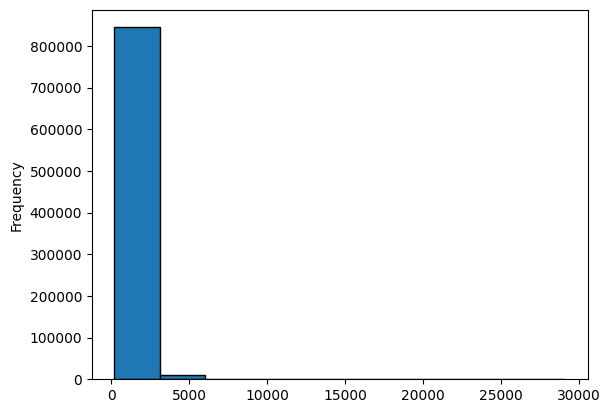

In [43]:
train['text_length'].plot(kind='hist', edgecolor='black')

We already knew that this column isn't normal so we will use U-test for hypothesis testing.

First we will generate the data to compare weekdays and weekends and then we will use the U-test to do the Hypothesis testing:

X: weekends, Y: weekdays

H0 : μx < μy

H1 : μx >= μy

In [44]:
t = train.copy()
t["wd"] = t["reviewTime"].dt.weekday

In [45]:
twe = t[t["wd"]>=6]
twd = t[t["wd"]<6]

In [46]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(twe['text_length'], twd['text_length'], alternative="greater")
p_value

0.0023741145530308443

As you can see, this hypothesis is rejected due to lack of evidence and therefore we can't come to the result that weekdays comments are longer.

Let's see if the opposite is true though:

In [47]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(twd['text_length'], twe['text_length'], alternative="greater")
p_value

0.9976258855439618

So we can say that comments on weekends are longer with a very vast confidence interval. And it kinda makes sense!

In [48]:
twe["text_length"].mean(), twd["text_length"].mean()

(628.9207623600682, 622.386974715577)

In [49]:
twe["text_length"].std(), twd["text_length"].std()

(699.0201454068848, 679.7909511281066)

Again greater mean, smaller std.


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Third Hypothesis: 
</font>
</h3>

Is overall affected by text length?

<Axes: ylabel='Frequency'>

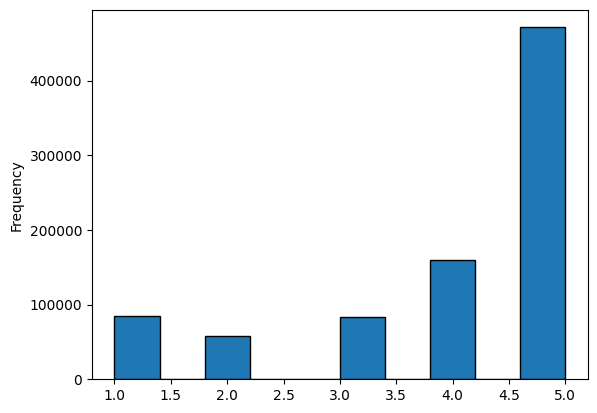

In [50]:
train['overall'].plot(kind='hist', edgecolor='black')

We already knew that this column isn't normal so we will use U-test for hypothesis testing.

First we will generate the data to compare weekdays and weekends and then we will use the U-test to do the Hypothesis testing:

X: after median, Y: before median

H0 : μx < μy

H1 : μx >= μy

Due to massive number of outliers, the mean is pretty biased so we will use median to determine which half a comment is.

In [51]:
t = train.copy()
m = t["text_length"].median()
m

407.0

In [52]:
tam = t[t["text_length"]>m]
tbm = t[t["text_length"]<=m]

In [53]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(tam['overall'], tbm['overall'], alternative="greater")
p_value

1.0

So we can say that the more a customer is satisfied with a product, the less thay bother to type long comments!

In [54]:
tam["overall"].mean(), tbm["overall"].mean()

(3.9606608123147136, 4.085698997343228)

In [55]:
tam["overall"].std(), tbm["overall"].std()

(1.3504601547695543, 1.3336080697037678)

Unlike the other hypothesis that we have already discussed this time, the std of the greater class is greaater but the mean difference is so big that the respective bias doesen't afffect the U-test result.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Fourth Hypothesis: 
</font>
</h3>

Is overall affected by verification status?

<Axes: ylabel='Frequency'>

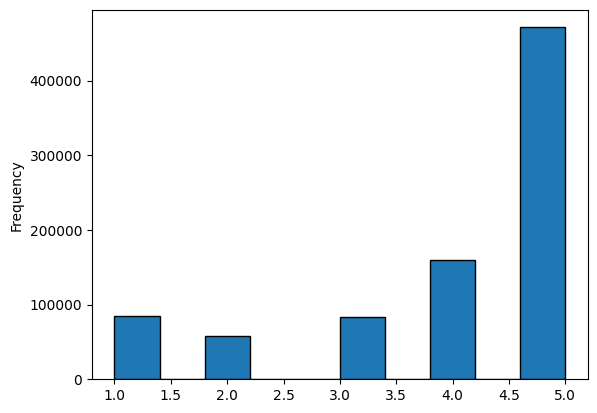

In [56]:
train['overall'].plot(kind='hist', edgecolor='black')

We already knew that this column isn't normal so we will use U-test for hypothesis testing.

First we will generate the data to compare weekdays and weekends and then we will use the U-test to do the Hypothesis testing:

X: not-verified, Y: verified

H0 : μx < μy

H1 : μx >= μy

In [57]:
t = train.copy()

In [58]:
tv = t[t["verified"]==1]
tnv = t[t["verified"]==0]

In [59]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(tnv['overall'], tv['overall'], alternative="greater")
p_value

1.0

So we can say that verified comments are generally the ones that have a higher overall score!

In [60]:
tnv["overall"].mean(), tv["overall"].mean()

(3.9511092680904003, 4.0350222553543444)

In [61]:
tnv["overall"].std(), tv["overall"].std()

(1.3853015570131757, 1.336163389117831)

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Data Explanation:
</font>
</h3>

In [62]:
train

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,title,brand,text_length
0,2,0.0,0,2016-11-11,A2OSUEZJIN7BI,0511189877,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,561
1,5,0.0,1,2016-06-06,A2NETQRG6JHIG7,0511189877,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,450
2,4,0.0,1,2016-03-10,A12JHGROAX49G7,0511189877,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,205
3,5,0.0,1,2016-01-14,A1KV65E2TMMG6F,0511189877,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,284
4,5,0.0,1,2016-10-20,A280POPEWI0NSA,0594459451,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble,247
...,...,...,...,...,...,...,...,...,...,...,...,...
855674,5,0.0,1,2017-07-25,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,These are my favorite charging cords for a few...,Worth the price.,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO,276
855675,1,0.0,1,2017-04-04,A77K1B31UAQ29,B01HJCN1EI,addictedtoreading,"Update....after 2 months of gentle use, cable ...",UPDATE...BREAKS AND SLOW CHARGING,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO,228
855676,3,0.0,1,2017-07-08,A2SVXUVUAWUDK2,B01HJH42KU,Andrew,These are okay. The connection becomes very if...,Hope this makes sense. You'd understand if you...,Jricoo Nylon Braided 2.0 Micro USB Charging Ca...,Jricoo,242
855677,5,2.0,1,2016-12-01,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,"Ok here is an odd thing that happened to me, I...",Not the correct product as linked in the sale.,Jricoo 3pack 6ft Micro USB to USB Cable 2.0 6f...,Jricoo,528


In [63]:
test

,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,0.0,1,2018-06-04,A20GGWE66JW9X2,B006Z394GM,Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...
1,0.0,1,2018-02-18,ARYJWXHEYHG9M,B005BE058W,Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR
2,0.0,1,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular
3,0.0,1,2018-06-25,A11VN8EOHNLP72,B00FBJ4KYC,Jeremy Bray,I purchased this 4 year protection plan for a ...,DO NOT BUY!!!
4,3.0,1,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy
...,...,...,...,...,...,...,...,...
19995,0.0,1,2016-08-18,A2938GNQGHT0BL,B01DACQMH4,Sarah White,"I've just had it up and running for 3 days, bu...",but so far I'm pretty pleased. I upgraded from...
19996,0.0,1,2018-04-09,ALL1OIDIGVJDH,B005HGM1D6,Amigaman,Looking for high quality audio interconnect ca...,High Quality Audio Interconnects
19997,0.0,1,2016-01-20,A17HGOTUOG2BFJ,B007FMG6D6,Luke Snedecor,Perfect! Does exactly as told. The cable is a ...,Totally works!
19998,3.0,1,2016-01-13,A1HC6MT5PMOIRN,B00KQCOV5C,Richmond Mensah,I bought this for my dell latitude e6330. I wa...,Dell latitude E6330


In [64]:
check = test[test["asin"].isin(train["asin"])].dropna()
check

,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,0.0,1,2018-06-04,A20GGWE66JW9X2,B006Z394GM,Brian C Toner,The name and description of this device are mi...,The prize for most useless invention of all ti...
1,0.0,1,2018-02-18,ARYJWXHEYHG9M,B005BE058W,Snake,One of the molex connectors on the power suppl...,MELTED MOLEX CONNECTOR
2,0.0,1,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,Amazon Customer,Remote constantly disconnects/ Roku player fre...,Bricked on the regular
4,3.0,1,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,Mark,I bought one of these and have regretted it ev...,Nightmare - don't buy
5,0.0,1,2017-09-15,ACZDN5A7ZH6RM,B006FKAZ36,Dj Breaz,Item came in with good timing. I went to use t...,Good Feel But Did Not Work.
...,...,...,...,...,...,...,...,...
19995,0.0,1,2016-08-18,A2938GNQGHT0BL,B01DACQMH4,Sarah White,"I've just had it up and running for 3 days, bu...",but so far I'm pretty pleased. I upgraded from...
19996,0.0,1,2018-04-09,ALL1OIDIGVJDH,B005HGM1D6,Amigaman,Looking for high quality audio interconnect ca...,High Quality Audio Interconnects
19997,0.0,1,2016-01-20,A17HGOTUOG2BFJ,B007FMG6D6,Luke Snedecor,Perfect! Does exactly as told. The cable is a ...,Totally works!
19998,3.0,1,2016-01-13,A1HC6MT5PMOIRN,B00KQCOV5C,Richmond Mensah,I bought this for my dell latitude e6330. I wa...,Dell latitude E6330


We know that some of test asins are not available in the train data asin so we must make sure that we will get rid of that column when we are in part 3.

For part 2, we will limit our overall mean to our train dataset.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Part 2:
</font>
</h3>

Finding warrantee related overall score for each product:

First of all, a little bit of text processing related work:

In [65]:
punctuation = list(string.punctuation)
stop_words.update(punctuation)
stop_words

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'bought',
 'but',
 'by',
 'camera',
 'can',
 'case',
 'could',
 'couldn',
 "couldn't",
 'd',
 'device',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'even',
 'few',
 'for',
 'from',
 'further',
 'get',
 'got',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'however',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'like',
 'll',
 

In [66]:
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

In [67]:
def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

In [68]:
def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

In [69]:
def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

In [70]:
def remove_stopwords(words):
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    return words

In [71]:
def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)

In [72]:
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [73]:
train["reviewText"] = train["reviewText"].apply(denoise_text)
test["reviewText"] = test["reviewText"].apply(denoise_text)

" Lemmatization produces a linguistically valid word while stemming is faster but may generate non-words. "

In [74]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

train['reviewText']  = train['reviewText'] .apply(lambda x: lemmatizer_on_text(x))
test['reviewText']  = test['reviewText'] .apply(lambda x: lemmatizer_on_text(x))

In [75]:
train

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,title,brand,text_length
0,2,0.0,0,2016-11-11,A2OSUEZJIN7BI,0511189877,Chris,older remote thought upgrade twc stuck fails d...,Cannot Learn,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,561
1,5,0.0,1,2016-06-06,A2NETQRG6JHIG7,0511189877,Qrysta White,first ive ever remote needed programming whats...,zero programming needed! Miracle!?,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,450
2,4,0.0,1,2016-03-10,A12JHGROAX49G7,0511189877,Linwood,worked company called feedback told send refun...,Works Good and programs easy.,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,205
3,5,0.0,1,2016-01-14,A1KV65E2TMMG6F,0511189877,Dane Williams,tired remote wrong side bed going buy generic ...,Same as TWC remote,CLIKR-5 Time Warner Cable Remote Control UR5U-...,URC,284
4,5,0.0,1,2016-10-20,A280POPEWI0NSA,0594459451,Kristina H.,purchasing cheap cords another website little ...,Good Quality Cord,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble,247
...,...,...,...,...,...,...,...,...,...,...,...,...
855674,5,0.0,1,2017-07-25,A1OOVLE2KZ6KGA,B01HJCN1EI,Puddzee,favorite charging cords reasons length means r...,Worth the price.,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO,276
855675,1,0.0,1,2017-04-04,A77K1B31UAQ29,B01HJCN1EI,addictedtoreading,updateafter months gentle cable twisted nearly...,UPDATE...BREAKS AND SLOW CHARGING,"Android charger cable 10 ft, Extra long Nylon ...",DEEGO,228
855676,3,0.0,1,2017-07-08,A2SVXUVUAWUDK2,B01HJH42KU,Andrew,okay connection becomes iffy uses especially e...,Hope this makes sense. You'd understand if you...,Jricoo Nylon Braided 2.0 Micro USB Charging Ca...,Jricoo,242
855677,5,2.0,1,2016-12-01,A2HUZO7MQAY5I2,B01HJH40WU,michael clontz,ok odd happened clicked sales item cable recei...,Not the correct product as linked in the sale.,Jricoo 3pack 6ft Micro USB to USB Cable 2.0 6f...,Jricoo,528


In [76]:
test

,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary
0,0.0,1,2018-06-04,A20GGWE66JW9X2,B006Z394GM,Brian C Toner,name description misleading supposed conversio...,The prize for most useless invention of all ti...
1,0.0,1,2018-02-18,ARYJWXHEYHG9M,B005BE058W,Snake,molex connectors power supply started melting ...,MELTED MOLEX CONNECTOR
2,0.0,1,2018-01-20,A10LHZ7WFZ7HLL,B01DA0YCNC,Amazon Customer,remote constantly disconnects roku player free...,Bricked on the regular
3,0.0,1,2018-06-25,A11VN8EOHNLP72,B00FBJ4KYC,Jeremy Bray,purchased year protection plan security system...,DO NOT BUY!!!
4,3.0,1,2016-08-17,A194Y8P8TVT7P9,B00P7G82TS,Mark,regretted ever since gps receiver worked day h...,Nightmare - don't buy
...,...,...,...,...,...,...,...,...
19995,0.0,1,2016-08-18,A2938GNQGHT0BL,B01DACQMH4,Sarah White,ive running days far im pretty pleased upgrade...,but so far I'm pretty pleased. I upgraded from...
19996,0.0,1,2018-04-09,ALL1OIDIGVJDH,B005HGM1D6,Amigaman,looking high quality audio interconnect cables...,High Quality Audio Interconnects
19997,0.0,1,2016-01-20,A17HGOTUOG2BFJ,B007FMG6D6,Luke Snedecor,perfect exactly told cable ittle short mean no...,Totally works!
19998,3.0,1,2016-01-13,A1HC6MT5PMOIRN,B00KQCOV5C,Richmond Mensah,dell latitude doubting computer support ram gr...,Dell latitude E6330


In [77]:
train.to_csv("newtrain.csv")
test.to_csv("newtest.csv")

Now we can get to the KPI assessment part:

In [78]:
df = train[["asin", "reviewText", "overall"]]
df

,asin,reviewText,overall
0,0511189877,older remote thought upgrade twc stuck fails d...,2
1,0511189877,first ive ever remote needed programming whats...,5
2,0511189877,worked company called feedback told send refun...,4
3,0511189877,tired remote wrong side bed going buy generic ...,5
4,0594459451,purchasing cheap cords another website little ...,5
...,...,...,...
855674,B01HJCN1EI,favorite charging cords reasons length means r...,5
855675,B01HJCN1EI,updateafter months gentle cable twisted nearly...,1
855676,B01HJH42KU,okay connection becomes iffy uses especially e...,3
855677,B01HJH40WU,ok odd happened clicked sales item cable recei...,5


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Guarantee & Warranty
</font>
</h3>

We'll use chatGPT for common mistakes and common synonyms for warranties and guarantees:

In [79]:
keywords = ["guarantee", "guaranteed", "guarantees", "warranty", "warranties", "warranted",
"assurance", "assured", "promised", "coverage", "insured", "warrantee",
"security", "pledge", "commitment", "contract", "protection", "safeguard",
"agreement", "bond", "certainty", "certified", "guarantor", "vouch", "pledged",
"ensured", "policy", "reassurance", "warranting", "certify", "promise",
"word", "wording", "guaranty", "pledge", "certification",
# Common typing issues and misspellings
"garantee", "waranty", "gaurantee", "warrantee", "garranty", "warantee",
"guarntee", "garanty", "gurantee", "waranties", "garantee", "guranty",
"guarnatee", "guarntee", "guaranties", "warrenty", "waranties", "warant",
"garentee", "guranty", "garanties", "warenty", "warrantees", "warraty"]

In [80]:
def mentions(text):
    for keyword in keywords:
        if re.search(rf'\b{re.escape(keyword)}\b', text, re.I):
            return True
    return False

In [81]:
filtered_df = df[df['reviewText'].apply(mentions)]
filtered_df

,asin,reviewText,overall
32,0972683275,bolts seems come loose sidetoside rotation im ...,3
53,140053271X,want topline ereader go kindle ereaders basic ...,4
78,1495443043,part sweet story interesting old adage love co...,3
122,980035977X,printer took call tplink tech support find hp ...,1
167,B000001OM4,adapter works well corvette issue sound qualit...,4
...,...,...,...
855614,B01HI9GG30,attractive solidly made cable unfortunately al...,1
855626,B01HIA63ZA,xti series corsairs flagship ssd ssd market pr...,5
855636,B01HIQYWU2,heres issue protects well fits perfectly fails...,3
855639,B01HIS3FGW,great worklaptop bag simplified travel love ba...,4


In [82]:
merged_data = pd.merge(filtered_df, titles, on='asin')
merged_data

,asin,reviewText,overall,title,brand
0,0972683275,bolts seems come loose sidetoside rotation im ...,3,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",VideoSecu
1,140053271X,want topline ereader go kindle ereaders basic ...,4,Barnes &amp; Noble Nook Simple Touch eBook Rea...,Barnes &amp; Noble
2,1495443043,part sweet story interesting old adage love co...,3,Country Heaven (Dare River),Visit Amazon's Ava Miles Page
3,980035977X,printer took call tplink tech support find hp ...,1,TP-LINK TL-PS110U Single USB2.0 port fast ethe...,TP-LINK
4,980035977X,around issue older hp multifunction printer ph...,5,TP-LINK TL-PS110U Single USB2.0 port fast ethe...,TP-LINK
...,...,...,...,...,...
61257,B01HH5G93C,ipad pro kiq tm heavy duty hybrid silicone ski...,5,iPad Pro 9.7 2016 case by KIQ Heavy Duty Hybri...,KIQ
61258,B01HHR572O,photographers shoot green mode shoot casually ...,5,Sigma SD Quattro Digital Camera with 30mm F1.4...,Sigma
61259,B01HHRGSEA,fourth tablets first three recieved physcial d...,1,9.7 inch Tablet Octa Core 2560X1600 IPS Blueto...,FX
61260,B01HI9GG30,attractive solidly made cable unfortunately al...,1,3.5mm Stereo Audio AUX Cable w/ Straight Male ...,Beautiful-tech


Now that we have filtered data and have the asin title, we can calculate the respective mean for each product:

In [83]:
grouped = pd.DataFrame(merged_data.groupby('title').agg(Mean=('overall', np.mean),Sum=('overall', np.sum))).reset_index()
grouped['Count'] = grouped["Sum"]/ grouped["Mean"]
grouped.drop(columns=["Sum"], inplace=True)

We assume that any score that is consisted of less than 10 votes is not that reliable so we will delete them.

In [84]:
grouped = grouped[grouped["Count"]>=10]

In [85]:
grouped = grouped.sort_values(["Mean", "Count"], ascending=False).reset_index(drop=True)
grouped

,title,Mean,Count
0,SE FC9955 Dummy Sensor Security Camera,5.000000,43.0
1,Case Logic CDW-32 32 Capacity Classic CD Walle...,5.000000,16.0
2,Koss SportaPro Stereo Headphones,5.000000,16.0
3,OP/TECH USA Utility Strap - Swivel (Black),5.000000,16.0
4,Blitzby Apple Watch Screen Protector 44mm (7 P...,5.000000,13.0
...,...,...,...
879,Amp Wiring Kit | BOSS Audio KIT-ZERO 10 Gauge ...,1.750000,16.0
880,D-Link Camera Video Recorder mydlink-Enabled (...,1.750000,12.0
881,SuperSonic 1080p LED Widescreen HDTV with HDMI...,1.700000,10.0
882,Seagate Backup Plus Slim 2TB Portable Hard Dri...,1.647059,17.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Top 15 Guarantee Wise:
</font>
</h3>

In [86]:
grouped.head(15)

,title,Mean,Count
0,SE FC9955 Dummy Sensor Security Camera,5.0,43.0
1,Case Logic CDW-32 32 Capacity Classic CD Walle...,5.0,16.0
2,Koss SportaPro Stereo Headphones,5.0,16.0
3,OP/TECH USA Utility Strap - Swivel (Black),5.0,16.0
4,Blitzby Apple Watch Screen Protector 44mm (7 P...,5.0,13.0
5,OMOTON Kindle Paperwhite Case Cover - The Thin...,5.0,13.0
6,Alcoco Headphpone Splitter Adapter Jack Adapto...,5.0,12.0
7,Domke F-34M 15-Inch Protective Wrap -Gray,5.0,12.0
8,Kingwin Aluminum Single Bay Hot Swap Mobile Ra...,5.0,12.0
9,Nikon 52mm Screw-on NC Filter,5.0,12.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Worst 15 Guarantee Wise:
</font>
</h3>

In [87]:
grouped.tail(15)

,title,Mean,Count
869,Uniden UDR444 Guardian 4.3-Inch Video Surveill...,2.000000,10.0
870,CANARY (CAN100USBK) All-in-One Indoor 1080p HD...,1.980392,51.0
871,FLIR FX Indoor Wi-Fi Wireless 1080P HD Video M...,1.928571,14.0
872,(Old Model) Seagate 500GB Desktop HDD SATA 6Gb...,1.925926,27.0
873,Samsung EVO 64GB 48/MB/s Micro SDXC Memory Ca...,1.909091,55.0
874,GoPro HERO4 Silver,1.900000,10.0
875,SmartGuard 13-Month Tablet Accident Protection...,1.900000,10.0
876,Zmodo SPoE Security System - 4 Channel NVR &am...,1.900000,10.0
877,Lexar High-Performance microSDHC 633x 16GB UHS...,1.882353,17.0
878,Microsoft Band 2 - Medium,1.796296,54.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Overview:
</font>
</h3>

In [88]:
grouped["Label"] = grouped["Mean"]
grouped["Is_High"] = np.where(grouped["Mean"]>3.5, 1, 0)
grouped["Is_Low"] = np.where((grouped["Mean"]<2.5), 1, 0)
grouped["Is_Neut"] = np.where((grouped["Mean"]>=2.5) & (grouped["Mean"]<=3.5), 1, 0)
h = grouped["Is_High"].sum()
l = grouped["Is_Low"].sum()
n = grouped["Is_Neut"].sum()
h, n, l

(606, 230, 48)

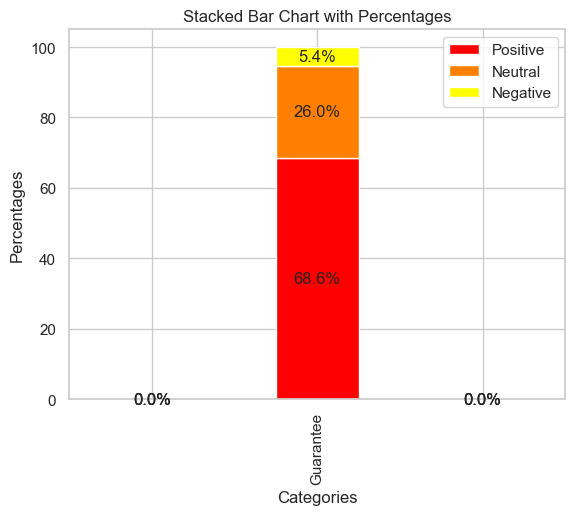

In [89]:
var1 = h
var2 = n
var3 = l

total = var1 + var2 + var3

percentage_var1g = (var1 / total) * 100
percentage_var2g = (var2 / total) * 100
percentage_var3g = (var3 / total) * 100

data = {'Category': ['', 'Guarantee', ''], 'Positive': [0, percentage_var1g, 0], 'Neutral': [0, percentage_var2g, 0], 'Negative': [0, percentage_var3g, 0]}
df = pd.DataFrame(data)

sns.set(style="whitegrid")  # Set the style (optional)
ax = df.plot(x='Category', kind='bar', stacked=True, colormap='autumn')

for container in ax.containers:
    ax.bar_label(container, fmt='%1.1f%%', label_type='center')

plt.xlabel('Categories')
plt.ylabel('Percentages')
plt.title('Stacked Bar Chart with Percentages')
plt.show()

We can do the same thing for different KPIs.

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Price
</font>
</h3>

In [90]:
df = train[["asin", "reviewText", "overall"]]
df

,asin,reviewText,overall
0,0511189877,older remote thought upgrade twc stuck fails d...,2
1,0511189877,first ive ever remote needed programming whats...,5
2,0511189877,worked company called feedback told send refun...,4
3,0511189877,tired remote wrong side bed going buy generic ...,5
4,0594459451,purchasing cheap cords another website little ...,5
...,...,...,...
855674,B01HJCN1EI,favorite charging cords reasons length means r...,5
855675,B01HJCN1EI,updateafter months gentle cable twisted nearly...,1
855676,B01HJH42KU,okay connection becomes iffy uses especially e...,3
855677,B01HJH40WU,ok odd happened clicked sales item cable recei...,5


In [91]:
keywords = [
    'Price', 'Cost', 'Expense', 'Fee', 'Charge', 'Rate', 'Value', 'Retail', 'Wholesale',
    'MSRP', 'List price', 'Discount', 'Sale', 'Bargain', 'Offer', 'Deal', 'Quote', 'Estimate',
    'Pricing', 'Budget', 'Affordable', 'Expensive', 'Premium', 'Luxury', 'Inexpensive',
    'Cost-effective', 'Price tag', 'Quotation', 'Invoice', 'High price', 'Low price', 'Online price', 'Final price',
    'Price range', 'Discounted price', 'Best price', 'Affordable price',
    'Price comparison', 'Price quote', 'Price list', 'Sale price',
    'Wholesale price', 'Retail price', 'Market price', 'Fixed price',
    'Negotiated price', 'Competitive price', 'Price adjustment',
    'Markup', 'Markdown', 'Price cut', 'Price increase', 'Pricing strategy',
    'Priced out', 'Pricer', 'Pricy', 'Expensiv', 'Pricey',
    'Pric', 'Pice', 'Pricce', 'Costt', 'Costr', 'Expanse', 'Expence', 'Charj', 'Rait', 'Vlaue',
    'Retaile', 'Wholeesale', 'Lisst price', 'Discont', 'Sail', 'Baragn', 'Offerr', 'Deel', 'Qote',
    'Estimatt', 'Pricng', 'Buget', 'Affordabe', 'Exspensive', 'Affordabel', 'Preamium', 'Luxuary',
    'Inexpensiv', 'Cost-effectiv', 'Price tage', 'Invoce',     'Pricce', 'Costt', 'Costr', 'Expanse', 'Expence', 'Charj',
    'Rait', 'Vlaue', 'Retaile', 'Wholeesale', 'Lisst price',
    'Discont', 'Sail', 'Baragn', 'Offerr', 'Deel', 'Qote',
    'Estimatt', 'Pricng', 'Buget', 'Affordabe', 'Exspensive',
    'Affordabel', 'Preamium', 'Luxuary', 'Inexpensiv',
    'Cost-effectiv', 'Price tage', 'Invioce'
]



In [92]:
def mentions(text):
    for keyword in keywords:
        if re.search(rf'\b{re.escape(keyword)}\b', text, re.I):
            return True
    return False

In [93]:
filtered_df = df[df['reviewText'].apply(mentions)]
filtered_df

,asin,reviewText,overall
4,0594459451,purchasing cheap cords another website little ...,5
10,0594296420,say works fine im sure purchased replace gen n...,5
14,059449771X,since still original nooks thought still charg...,3
16,0594450268,fits nook hd perfectly gave tablet new look mu...,5
18,073530498X,display vintage photos father taken overseas k...,5
...,...,...,...
855649,B01HIS365W,ive amazing weeks ago amazing leef lexar sandi...,5
855652,B01HIS5N3K,third jam speaker small jam another symphony g...,3
855654,B01HITUTV0,great well worth price safety expensive equipm...,5
855672,B01HJDNL60,review covers vantrue dash cameras purchased c...,3


In [94]:
merged_data = pd.merge(filtered_df, titles, on='asin')
merged_data

,asin,reviewText,overall,title,brand
0,0594459451,purchasing cheap cords another website little ...,5,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble
1,0594459451,thank heavens improved personally three nook c...,5,Barnes &amp; Noble Nook Color Tablet USB Cable...,Barnes &amp; Noble
2,0594296420,say works fine im sure purchased replace gen n...,5,Barnes &amp; Noble Power Adapter for Nook Simp...,Barnes &amp; Noble
3,059449771X,since still original nooks thought still charg...,3,Barnes &amp; Noble Replacement Charging Sync C...,Barnes & Noble
4,0594450268,fits nook hd perfectly gave tablet new look mu...,5,Nook Hd + 9-Inch Groovy Protective Stand Cover...,Nook
...,...,...,...,...,...
276028,B01HIM7D8Y,surprisingly sturdy price held breath twisting...,5,Raking Universal iPhone Holder/iPad Stand/Cell...,Raking
276029,B01HIQYWU2,heres issue protects well fits perfectly fails...,3,Brenthaven BX2 Edge Case | 360-Degree Protecti...,Brenthaven
276030,B01HIS3FGW,nothing particularly wrong backpack price real...,3,"Case Logic HUXDP115 Huxton Daypack, Midnight Blue",Case Logic
276031,B01HIS365W,ive amazing weeks ago amazing leef lexar sandi...,5,Lightning microSD Card Reader for iPhone and iPad,PNY


In [95]:
grouped = pd.DataFrame(merged_data.groupby('title').agg(Mean=('overall', np.mean),Sum=('overall', np.sum))).reset_index()
grouped['Count'] = grouped["Sum"]/ grouped["Mean"]
grouped.drop(columns=["Sum"], inplace=True)

In [96]:
grouped = grouped[grouped["Count"]>=10]

In [97]:
grouped = grouped.sort_values(["Mean", "Count"], ascending=False).reset_index(drop=True)
grouped

,title,Mean,Count
0,SLIK Complete Tripod Pro 700DX Amt Tripod with...,5.000000,64.0
1,SE FC9955 Dummy Sensor Security Camera,5.000000,43.0
2,Nikon Lens Pen Cleaning System,5.000000,32.0
3,AT&amp;T 25-Ft. Line Cord (White),5.000000,28.0
4,Canon EF 400mm f/5.6L USM Super Telephoto Lens...,5.000000,28.0
...,...,...,...
5646,Samsung SNH-P6410BN SmartCam HD Pro 1080p Full...,2.076923,13.0
5647,NETGEAR Nighthawk AC1900 VDSL/ADSL Modem Route...,2.052632,19.0
5648,"Nikon DK-5 Eyepiece Cap for Nikon D200, D70S a...",2.000000,12.0
5649,CANARY (CAN100USBK) All-in-One Indoor 1080p HD...,1.891304,46.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Top 15 Price Wise:
</font>
</h3>

In [98]:
grouped.head(15)

,title,Mean,Count
0,SLIK Complete Tripod Pro 700DX Amt Tripod with...,5.0,64.0
1,SE FC9955 Dummy Sensor Security Camera,5.0,43.0
2,Nikon Lens Pen Cleaning System,5.0,32.0
3,AT&amp;T 25-Ft. Line Cord (White),5.0,28.0
4,Canon EF 400mm f/5.6L USM Super Telephoto Lens...,5.0,28.0
5,Pelican Micro Case Waterproof Container,5.0,28.0
6,"BIC America DV62si Bookshelf Speakers (Pair, B...",5.0,24.0
7,Nikon D500 DX-Format Digital SLR with 16-80mm ...,5.0,22.0
8,"MoKo iPad Mini 3 / 2 / 1 Case, Slim-Fit Cover ...",5.0,21.0
9,Canon EF 135mm f/2L USM Lens for Canon SLR Cam...,5.0,20.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Worst 15 Price Wise:
</font>
</h3>

In [99]:
grouped.tail(15)

,title,Mean,Count
5636,Linksys AC3200 Tri-Band Smart Wi-Fi Router wit...,2.466667,15.0
5637,Sony STR-DN850 7.2 Channel 4K AV Receiver (Bui...,2.466667,15.0
5638,Netgear R7500-200NAS Nighthawk X4 Ultimate Gam...,2.400000,10.0
5639,Seagate Wireless Plus 1TB Portable Hard Drive ...,2.363636,11.0
5640,D-Link 4-Port USB 2.0 Hub including 4 Fast Cha...,2.333333,12.0
5641,"Microsoft Surface Pro 4 (256 GB, 8 GB RAM, Int...",2.285714,14.0
5642,Microsoft 7N9-00001 Designer Bluetooth Desktop,2.272727,11.0
5643,Microsoft Arc Touch Bluetooth Mouse,2.266667,15.0
5644,Speck Products 71575-1212 SeeThru Case for Mac...,2.200000,10.0
5645,Nikon KeyMission 360,2.150000,20.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Overview:
</font>
</h3>

In [100]:
grouped["Label"] = grouped["Mean"]
grouped["Is_High"] = np.where(grouped["Mean"]>3.5, 1, 0)
grouped["Is_Low"] = np.where((grouped["Mean"]<2.5), 1, 0)
grouped["Is_Neut"] = np.where((grouped["Mean"]>=2.5) & (grouped["Mean"]<=3.5), 1, 0)
h = grouped["Is_High"].sum()
l = grouped["Is_Low"].sum()
n = grouped["Is_Neut"].sum()
h, n, l

(5174, 462, 15)

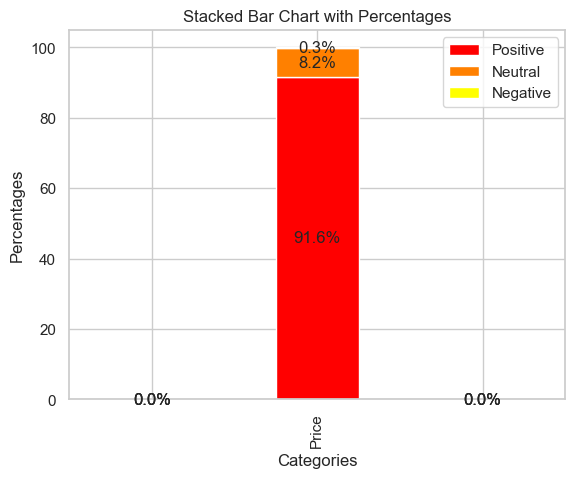

In [101]:
var1 = h
var2 = n
var3 = l

total = var1 + var2 + var3

percentage_var1p = (var1 / total) * 100
percentage_var2p = (var2 / total) * 100
percentage_var3p = (var3 / total) * 100

data = {'Category': ['', 'Price', ''], 'Positive': [0, percentage_var1p, 0], 'Neutral': [0, percentage_var2p, 0], 'Negative': [0, percentage_var3p, 0]}
df = pd.DataFrame(data)

sns.set(style="whitegrid")  # Set the style (optional)
ax = df.plot(x='Category', kind='bar', stacked=True, colormap='autumn')

for container in ax.containers:
    ax.bar_label(container, fmt='%1.1f%%', label_type='center')

plt.xlabel('Categories')
plt.ylabel('Percentages')
plt.title('Stacked Bar Chart with Percentages')
plt.show()

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Safety
</font>
</h3>

In [102]:
df = train[["asin", "reviewText", "overall"]]
df

,asin,reviewText,overall
0,0511189877,older remote thought upgrade twc stuck fails d...,2
1,0511189877,first ive ever remote needed programming whats...,5
2,0511189877,worked company called feedback told send refun...,4
3,0511189877,tired remote wrong side bed going buy generic ...,5
4,0594459451,purchasing cheap cords another website little ...,5
...,...,...,...
855674,B01HJCN1EI,favorite charging cords reasons length means r...,5
855675,B01HJCN1EI,updateafter months gentle cable twisted nearly...,1
855676,B01HJH42KU,okay connection becomes iffy uses especially e...,3
855677,B01HJH40WU,ok odd happened clicked sales item cable recei...,5


In [103]:
keywords = [
    'Safety', 'Security', 'Protection', 'Secure', 'Guard', 'Shield', 'Defense', 'Safe',
    'Emergency', 'Risk', 'Precaution', 'Hazard', 'Caution', 'Alert', 'Accident', 'First aid',
    'Health', 'Well-being', 'Fire safety', 'Safety measures', 'Safety equipment', 'Safety precautions',
    'Safety procedures', 'Safety guidelines', 'Safety rules', 'Safety regulations', 'Safety standards',
    'Safety training', 'Safety inspection', 'Safety awareness', 'Safety culture',
    'Childproofing', 'Crisis management', 'Ergonomics', 'Risk assessment',
    'Safty', 'Securty', 'Protecton', 'Secur', 'Gaurd', 'Sheild', 'Defence', 'Safte',
    'Eemrgency', 'Risc', 'Precauton', 'Hazrd', 'Cauton', 'Allert', 'Acident', 'First aid',
    'Helth', 'Well-beeing'
]



In [104]:
def mentions(text):
    for keyword in keywords:
        if re.search(rf'\b{re.escape(keyword)}\b', text, re.I):
            return True
    return False

In [105]:
filtered_df = df[df['reviewText'].apply(mentions)]
filtered_df

,asin,reviewText,overall
28,0972683275,originally sony tv installed vizio instead son...,5
53,140053271X,want topline ereader go kindle ereaders basic ...,4
122,980035977X,printer took call tplink tech support find hp ...,1
129,9803750623,decided try see old emergency radio dynamo cha...,5
136,9806010728,good clips secure power splitter main result s...,4
...,...,...,...
855639,B01HIS3FGW,great worklaptop bag simplified travel love ba...,4
855653,B01HITUTV0,great item extra security buy shoulder straps ...,5
855654,B01HITUTV0,great well worth price safety expensive equipm...,5
855655,B01HITUTV0,everything absolutely perfect accurate day del...,5


In [106]:
merged_data = pd.merge(filtered_df, titles, on='asin')
merged_data

,asin,reviewText,overall,title,brand
0,0972683275,originally sony tv installed vizio instead son...,5,"VideoSecu 24"" Long Arm TV Wall Mount Low Profi...",VideoSecu
1,140053271X,want topline ereader go kindle ereaders basic ...,4,Barnes &amp; Noble Nook Simple Touch eBook Rea...,Barnes &amp; Noble
2,980035977X,printer took call tplink tech support find hp ...,1,TP-LINK TL-PS110U Single USB2.0 port fast ethe...,TP-LINK
3,980035977X,around issue older hp multifunction printer ph...,5,TP-LINK TL-PS110U Single USB2.0 port fast ethe...,TP-LINK
4,9803750623,decided try see old emergency radio dynamo cha...,5,USB 2.0 male to 3.5mm 5V DC Power Cable Barrel...,WDLLC
...,...,...,...,...,...
61448,B01HI9ZK8M,converter ok color shows electrified line show...,2,Mifine 1080P MINI HDMI to AV 3RCA CVBs Composi...,Mifine
61449,B01HICMC3A,extremely portable perfect onthego usb hub wor...,5,"USB-C Hub, EC Technology 4 ports USB 3.0 hub f...",EC Technology
61450,B01HIM7D8Y,surprisingly sturdy price held breath twisting...,5,Raking Universal iPhone Holder/iPad Stand/Cell...,Raking
61451,B01HIS3FGW,great worklaptop bag simplified travel love ba...,4,"Case Logic HUXDP115 Huxton Daypack, Midnight Blue",Case Logic


In [107]:
grouped = pd.DataFrame(merged_data.groupby('title').agg(Mean=('overall', np.mean),Sum=('overall', np.sum))).reset_index()
grouped['Count'] = grouped["Sum"]/ grouped["Mean"]
grouped.drop(columns=["Sum"], inplace=True)

In [108]:
grouped = grouped[grouped["Count"]>=10]

In [109]:
grouped = grouped.sort_values(["Mean", "Count"], ascending=False).reset_index(drop=True)
grouped

,title,Mean,Count
0,SE FC9955 Dummy Sensor Security Camera,5.000000,43.0
1,Pelican 1200 Case With Foam (Black),5.000000,36.0
2,Pelican 1400 Case With Foam (Black),5.000000,24.0
3,Canon Deluxe Gadget Bag 100EG,5.000000,16.0
4,Legrand - Wiremold CDG-15 Corduct Overfloor Co...,5.000000,16.0
...,...,...,...
871,CANARY (CAN100USBK) All-in-One Indoor 1080p HD...,2.269231,52.0
872,Matricom G-Box Q&sup2; Android TV Streaming Me...,2.200000,10.0
873,FLIR FX Indoor Wi-Fi Wireless 1080P HD Video M...,2.083333,12.0
874,OP/TECH USA 1501372 Pro Loop Strap for Camera ...,2.000000,12.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Top 15 Safety Wise:
</font>
</h3>

In [110]:
grouped.head(15)

,title,Mean,Count
0,SE FC9955 Dummy Sensor Security Camera,5.0,43.0
1,Pelican 1200 Case With Foam (Black),5.0,36.0
2,Pelican 1400 Case With Foam (Black),5.0,24.0
3,Canon Deluxe Gadget Bag 100EG,5.0,16.0
4,Legrand - Wiremold CDG-15 Corduct Overfloor Co...,5.0,16.0
5,Canon Zoom Pack 1000 for Elan and Rebel Series...,5.0,12.0
6,Case Logic CDW-32 32 Capacity Classic CD Walle...,5.0,12.0
7,MobileEdge Touch Screen Tablet Computer Cases ...,5.0,12.0
8,"NETGEAR 8-Port Fast Ethernet Unmanaged Switch,...",5.0,12.0
9,Nikon 52mm Screw-on NC Filter,5.0,12.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Worst 15 Safety Wise:
</font>
</h3>

In [111]:
grouped.tail(15)

,title,Mean,Count
861,D-Link DCS-934L Day &amp; Night Wi-Fi Camera (...,2.666667,15.0
862,D-Link Wi-Fi Camera with Remote Viewing (DCS-9...,2.615385,13.0
863,Foscam FI9821P HD 720P WiFi Security IP Camera...,2.588235,17.0
864,Samsung SNH-V6414BN SmartCam HD Plus 1080p Wi-...,2.555556,18.0
865,"Tenergy Propel 3V CR123A Lithium Battery, Hig...",2.526316,19.0
866,Amp Wiring Kit | BOSS Audio KIT-ZERO 10 Gauge ...,2.500000,40.0
867,Arlo - Wireless Home Security Camera System wi...,2.500000,14.0
868,NETGEAR AC5300 Nighthawk X8 Tri-Band WiFi Rout...,2.416667,12.0
869,eTopxizu 12v 30a Dc Universal Regulated Switch...,2.400000,10.0
870,Piper nv Security Camera with Door/Window Sens...,2.300000,10.0


<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Overview:
</font>
</h3>

In [112]:
grouped["Label"] = grouped["Mean"]
grouped["Is_High"] = np.where(grouped["Mean"]>3.5, 1, 0)
grouped["Is_Low"] = np.where((grouped["Mean"]<2.5), 1, 0)
grouped["Is_Neut"] = np.where((grouped["Mean"]>=2.5) & (grouped["Mean"]<=3.5), 1, 0)
h = grouped["Is_High"].sum()
l = grouped["Is_Low"].sum()
n = grouped["Is_Neut"].sum()
h, n, l

(772, 96, 8)

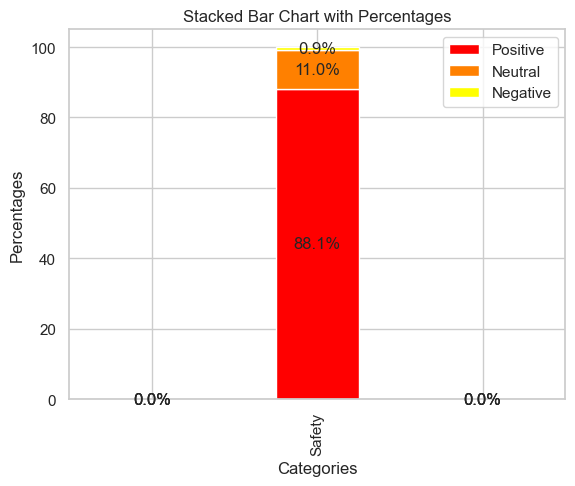

In [113]:
var1 = h
var2 = n
var3 = l

total = var1 + var2 + var3

percentage_var1s = (var1 / total) * 100
percentage_var2s = (var2 / total) * 100
percentage_var3s = (var3 / total) * 100

data = {'Category': ['', 'Safety', ''], 'Positive': [0, percentage_var1s, 0], 'Neutral': [0, percentage_var2s, 0], 'Negative': [0, percentage_var3s, 0]}
df = pd.DataFrame(data)

sns.set(style="whitegrid")
ax = df.plot(x='Category', kind='bar', stacked=True, colormap='autumn')

for container in ax.containers:
    ax.bar_label(container, fmt='%1.1f%%', label_type='center')

plt.xlabel('Categories')
plt.ylabel('Percentages')
plt.title('Stacked Bar Chart with Percentages')
plt.show()

<h3 align=left style="line-height:300%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
Conclusion:
</font>
</h3>

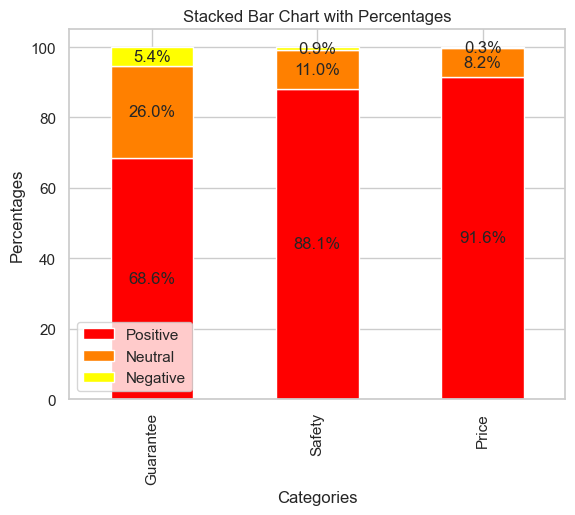

In [114]:
data = {'Category': ['Guarantee', 'Safety', 'Price'], 'Positive': [percentage_var1g, percentage_var1s, percentage_var1p], 'Neutral': [percentage_var2g, percentage_var2s, percentage_var2p], 'Negative': [percentage_var3g, percentage_var3s, percentage_var3p]}
df = pd.DataFrame(data)

sns.set(style="whitegrid")
ax = df.plot(x='Category', kind='bar', stacked=True, colormap='autumn')

for container in ax.containers:
    ax.bar_label(container, fmt='%1.1f%%', label_type='center')

plt.xlabel('Categories')
plt.ylabel('Percentages')
plt.title('Stacked Bar Chart with Percentages')
plt.show()

This is our final notebook for the first two parts, we will use train and test datasets for part three.